# Electron equivalent ellipse calculation

This calculates the length and width of the equivalent ellipse of cutouts defined appropriately within `shape_definition_x_coords.csv` and `shape_definition_y_coords.csv`. The measured cutout factors defined within `measured_cutout_factors.csv` are also used to calculate the equivalent ellipse.

The widths and lengths are then output into `measured_cutout_factors.csv` for the input into `Electron Spline Modelling.ipynb`.

In [1]:
energyRequest = 12
applicatorRequest = 10

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Loading/installing modules

In [2]:
try:
    import shapely.geometry as geo
    import shapely.affinity as aff
    
except:
    !pip install shapely
    import shapely.geometry as geo
    import shapely.affinity as aff
    

try:
    from descartes.patch import PolygonPatch
    
except:
    !pip install descartes
    from descartes.patch import PolygonPatch
    

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

from scipy.optimize import basinhopping
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import SmoothBivariateSpline

import os

## Importing input data

In [3]:
shape_definition_x_coords = pd.read_csv("../input/shape_definition_x_coords.csv")
shape_definition_y_coords = pd.read_csv("../input/shape_definition_y_coords.csv")

parsedInputs = pd.read_csv('../input/parsed_example.csv')

label = parsedInputs['label'].values

guessWidth = parsedInputs['width'].values
guessLength = parsedInputs['length'].values
factor = parsedInputs['cutout factor'].values

runInitialGuess = parsedInputs['make initial guess'].values
useForFitting = parsedInputs['use for fitting'].values
calcWidthLength = parsedInputs['recalc width and length'].values

In [4]:
useForFitting

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True], dtype=bool)

## Class and function definitions

### Pull coordinates for a given label

In [5]:
def return_coords(requestedLabel):
    
    cutoutXCoords = shape_definition_x_coords[requestedLabel].values
    cutoutXCoords = cutoutXCoords[~np.isnan(cutoutXCoords)]
    
    cutoutYCoords = shape_definition_y_coords[requestedLabel].values
    cutoutYCoords = cutoutYCoords[~np.isnan(cutoutYCoords)]
    
    return cutoutXCoords, cutoutYCoords

### Create shapely shapes

In [6]:
def shapely_cutout(XCoords,YCoords):
    """Returns the shapely cutout defined by the x and y coordinates.
    """
    return geo.Polygon(np.transpose((XCoords,YCoords)))


def shapely_ellipse(ellipseRaw):
    """Given raw ellipse values create a shapely ellipse.
    """
    xPosition = ellipseRaw[0]
    yPosition = ellipseRaw[1]

    width = ellipseRaw[2]
    length = ellipseRaw[3]

    rotation = ellipseRaw[4]


    unitCircle = geo.Point(0,0).buffer(1)        
    ellipse = aff.scale(unitCircle, xfact=width/2, yfact=length/2)    # Stretched
    ellipse = aff.translate(ellipse, xoff=xPosition, yoff=yPosition)  # Translated
    ellipse = aff.rotate(ellipse, rotation)                           # Rotated

    return ellipse

### Equivalent ellipse fitting

In [7]:
class equivalent_ellipse(object):
    """An equivalent ellipse given the x and y coordinates of a cutout.
    """
    def __init__(self, n=5, debug=False, **kwargs):
        
        self.debug = debug
        
        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
                
        self.basinRequiredSuccess = n
        self.ellipseRaw = self.ellipse_basinhopping()
        
        if abs(self.ellipseRaw[2]) < abs(self.ellipseRaw[3]):
            
            self.width = abs(self.ellipseRaw[2])
            self.length = abs(self.ellipseRaw[3])
            
        else:
            
            self.width = abs(self.ellipseRaw[3])
            self.length = abs(self.ellipseRaw[2])
 
            
        self.ellipse = shapely_ellipse(self.ellipseRaw)
    
    

 
    
    def minimise_function(self, ellipseRaw):
        """Returns the sum of area differences between the an ellipse and the given cutout.
        """
        ellipse = shapely_ellipse(ellipseRaw)
        
        return ellipse.difference(self.cutout).area + self.cutout.difference(ellipse).area
        
    
    def ellipse_basinhopping(self):
        """Fitting the ellipse to the cutout via scipy.optimize.basinhopping.
        """
        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS'}
        
        initial_input = np.array([0,0,3,4,0])
        
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)
        
        return basinhoppingOutput.x
        
        
    def step_function(self,optimiserInput):
        """Step function used by self.ellipse_basinhopping.
        """
        optimiserInput[0] += np.random.normal(scale=1.5)   # x-position
        optimiserInput[1] += np.random.normal(scale=1.5)   # y-position
        optimiserInput[2] += np.random.normal(scale=3)     # width
        optimiserInput[3] += np.random.normal(scale=4)     # length
        optimiserInput[4] += np.random.normal(scale=90)    # rotation
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
        """Callback function used by self.ellipse_basinhopping.
        """        
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + 0.0001:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - 0.0001:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - 0.0001:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True
        

### Make bivariate spline and produce the circle fit

In [9]:
# circle_fit(3)

### Sector integration

In [10]:
class sector_integration(object):
    
    def __init__(self, 
                 sectors=100, 
                 bound=25, 
                 ignoreUnexpectedIntersection=False,
                 **kwargs):
        
        self.ignoreUnexpectedIntersection = ignoreUnexpectedIntersection

        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
        
        self.circle_fit = kwargs['circle_fit']
                
        self.centre = [tuple(kwargs['centre'])]
        self.centreIsWithin = self.cutout.contains(geo.Point(self.centre))
        
        self.numSectors = sectors        
        resolution = int(self.numSectors/4)
        self.boundary = geo.Point(self.centre).buffer(bound*np.sqrt(2),resolution=resolution)
        
        self.factor = self.factor_calculate()
        
    
    
    def factor_calculate(self):
        
        self.sectorMidline = [0,]*self.numSectors
        self.intersectionSet = [0,]*self.numSectors
        
        self.sectorFactors = np.zeros(self.numSectors)
        
        for i in range(self.numSectors):
            
            self.sectorMidline[i] = geo.LineString(self.centre + [self.boundary.exterior.coords[i]])            
            self.intersectionSet[i] = self.sectorMidline[i].intersection(self.cutout.exterior)
            
            if type(self.intersectionSet[i]) is geo.point.Point:
                # One intersection occured

                if self.centreIsWithin:
                    # One intersection should only happen if the centre is within the shape
                    
                    dist = self.sectorMidline[i].project(self.intersectionSet[i])
                    
                    self.sectorFactors[i] = self.circle_fit(dist)
                    
                else:
                    
                    if self.ignoreUnexpectedIntersection:
                        self.sectorFactors[i] = np.nan
                    else:
                        raise Exception("Unexpected intersection result")
                    
            elif type(self.intersectionSet[i]) is geo.multipoint.MultiPoint:
                # Multiple intersections have occured
                
                dist = np.zeros(len(self.intersectionSet[i]))
                for j in range(len(self.intersectionSet[i])):
                    
                    point = self.intersectionSet[i][j]
                    dist[j] = self.sectorMidline[i].project(point)
                
                dist = np.sort(dist)
                
                if (np.mod(len(self.intersectionSet[i]),2) == 1 ) & (self.centreIsWithin):
                    # If the centre is within the shape, number of intersections must be odd
                    
                    self.sectorFactors[i] = sum(self.circle_fit(dist[::2])) - sum(self.circle_fit(dist[1::2]))
                    
                elif (np.mod(len(self.intersectionSet[i]),2) == 0 ) & (not(self.centreIsWithin)):
                    # If the centre is outside the shape, number of intersections must be even
            
                    self.sectorFactors[i] = sum(self.circle_fit(dist[1::2])) - sum(self.circle_fit(dist[::2]))
                
                else:
                    
                    if self.ignoreUnexpectedIntersection:
                        self.sectorFactors[i] = np.nan
                    else:
                        raise Exception("Unexpected intersection result")
                    
            elif (self.sectorMidline[i].disjoint(self.cutout.exterior)) & (not(self.centreIsWithin)):
                # No intersection
                0
                
            else:
                
                if self.ignoreUnexpectedIntersection:
                    self.sectorFactors[i] = np.nan
                else:
                    raise Exception("Unexpected intersection result")
    
        
        if self.ignoreUnexpectedIntersection:            
            factor = np.nanmean(self.sectorFactors)            
        else:            
            factor = np.mean(self.sectorFactors)
        
        
        return factor

### Finding centre with sector integration

In [11]:
class find_centre(object):
    
    def __init__(self, 
                 n=5, 
                 debug=False, 
                 confidence=0.001, 
                 sectors=100, 
                 ignoreUnexpectedIntersection=False,
                 **kwargs):
        
        self.debug = debug
        self.confidence = confidence
        self.sectors = sectors
        self.ignoreUnexpectedIntersection = ignoreUnexpectedIntersection
        
        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
        
        self.basinNoise = np.hypot(np.diff(self.cutout.bounds[::2]),np.diff(self.cutout.bounds[1::2]))/3
                
        self.circle_fit = kwargs['circle_fit']
        
        self.numCalls = 0
        self.basinRequiredSuccess = n
        self.centre = self.centre_basinhopping()
        
    
    
    def minimise_function(self, centre):
        
        sectorIntegrationInstance = sector_integration(x=self.cutoutXCoords,
                                                       y=self.cutoutYCoords,
                                                       circle_fit=self.circle_fit,
                                                       centre=centre,
                                                       sectors=self.sectors,
                                                       ignoreUnexpectedIntersection=self.ignoreUnexpectedIntersection)
        
        self.numCalls += 1
        
        return -sectorIntegrationInstance.factor
        
    
    def centre_basinhopping(self):
        
        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS',
                           "options": {'gtol': self.confidence}}
        
        initial_input = np.array([0,0])
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)   
        
        return basinhoppingOutput.x
    
    
    def step_function(self,optimiserInput):
        
        
        
        optimiserInput[0] += np.random.normal(scale=self.basinNoise)   # x-position
        optimiserInput[1] += np.random.normal(scale=self.basinNoise)   # y-position
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
        """Callback function used by self.ellipse_basinhopping.
        """        
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + self.confidence:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - self.confidence:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - self.confidence:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True    
        
        
    
    
    
#      def sector

In [12]:
x = np.array([1,2])

[tuple(x)]

[(1, 2)]

### Shape straightening

## Main

### Initial width and length guess

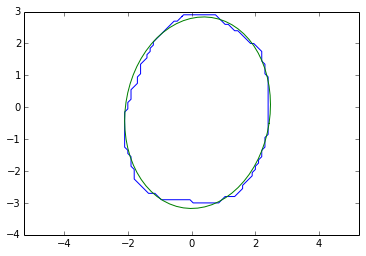

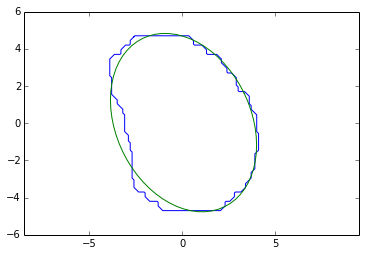

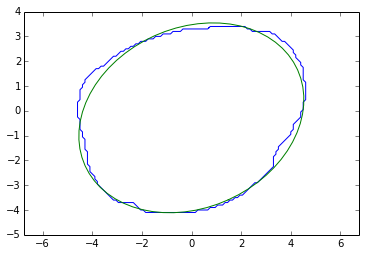

In [13]:
eqEllipses = [0,] * len(label)


for i in np.where(runInitialGuess)[0]:
    
    cutoutXCoords, cutoutYCoords = return_coords(label[i])
    
    eqEllipses[i] = equivalent_ellipse(x=cutoutXCoords,
                                       y=cutoutYCoords,
                                       n=2)
    
    guessWidth[i] = eqEllipses[i].width
    guessLength[i] = eqEllipses[i].length
    
    
    plt.plot(eqEllipses[i].cutout.exterior.xy[0],eqEllipses[i].cutout.exterior.xy[1])
    plt.plot(eqEllipses[i].ellipse.exterior.xy[0],eqEllipses[i].ellipse.exterior.xy[1])

    plt.axis("equal")

    plt.show()

In [14]:
guessWidth

array([ 4.5360547 ,  7.24513953,  4.4       ,  6.1       ,  7.6       ,
        5.8       ,  4.3       ,  5.2       ,  7.7       ,  5.9       ,
        7.        ,  4.7       ,  6.9       ,  6.1       ,  3.6       ,
        5.9       ,  7.5       ,  7.25300669,  6.3       ,  5.8       ,
        5.7       ,  6.1       ,  6.3       ,  3.5       ,  9.        ,
        8.        ,  6.        ,  4.        ,  7.        ,  3.        ,
        5.        ,  5.        ,  4.        ,  4.        ,  5.        ,
        3.        ,  3.        ,  4.        ,  3.        ,  4.        ,
        5.        ,  3.        ])

In [15]:
guessLength

array([  6.03573811,  10.06291486,   5.3       ,  10.5       ,
        10.1       ,  10.4       ,   5.1       ,  10.3       ,
        11.2       ,   6.2       ,   9.7       ,   5.7       ,
        10.        ,   7.7       ,   4.6       ,   7.5       ,
         8.4       ,   9.4011957 ,   8.        ,   7.9       ,
         8.3       ,   9.7       ,   7.8       ,   4.2       ,
         9.        ,   8.        ,   6.        ,   4.        ,
         7.        ,   3.        ,   5.        ,  13.        ,
        13.        ,   6.5       ,   8.        ,   6.5       ,
         5.        ,   8.        ,   9.        ,  10.        ,
        10.        ,  13.        ])

In [16]:
def make_spline_model(**kwargs):
    
    width = kwargs['width']
    length = kwargs['length']
    
    ratio = width/length
    eqPonA = 2*( 3*(ratio+1) - np.sqrt( (3*ratio+1)*(ratio+3) ) ) / width
    
    factor = kwargs['factor']
    
    return SmoothBivariateSpline(width, eqPonA, factor, kx=2, ky=2)


spline_model = make_spline_model(width=guessWidth[useForFitting],
                                 length=guessLength[useForFitting],
                                 factor=factor[useForFitting])

# Horrible programming!!
def circle_fit(radii):
        
        width = 2*radii
        eqPonA = 4/width
        
        return spline_model.ev(width,eqPonA)

### Find centre

#### Sanity check

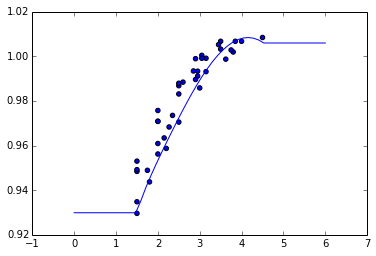

In [17]:
# Sanity check
t = np.linspace(0,6)
y = circle_fit(t)

plt.plot(t,y)
plt.scatter(guessWidth[useForFitting]/2,factor[useForFitting])

if sum(np.diff(y)) < 0:
    raise Exception("Cutout factor appears to be not defined according to TG25. " +
                    "Cutout factor should be increasing as radii increases.")
    
minEdgeDistance = np.min(guessWidth[useForFitting])

In [18]:
circle_fit(1)

array(0.9298767206848277)

In [19]:
factor[useForFitting]

array([ 0.9683,  0.9987,  0.9587,  1.0004,  1.0019,  0.9989,  0.9634,
        0.9884,  1.0067,  0.9933,  1.0067,  0.9735,  1.0052,  0.9437,
        0.9911,  1.0028,  0.9991,  0.9896,  0.9934,  0.9991,  0.9931,
        0.9489,  1.0084,  1.0067,  0.9858,  0.9562,  1.0032,  0.9296,
        0.9705,  0.9868,  0.9757,  0.9609,  0.9831,  0.9484,  0.9348,
        0.9708,  0.9492,  0.9709,  0.9879,  0.953 ])

#### Find centre of shapes to be recalced

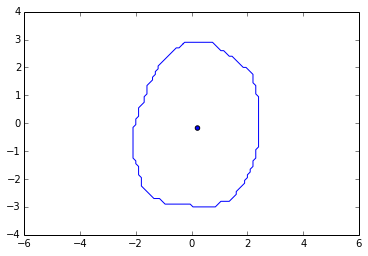

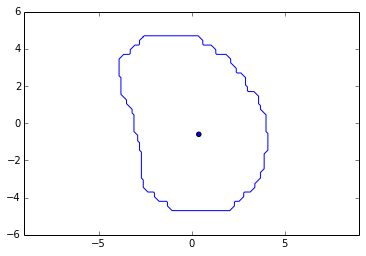

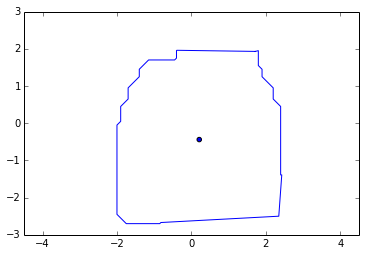

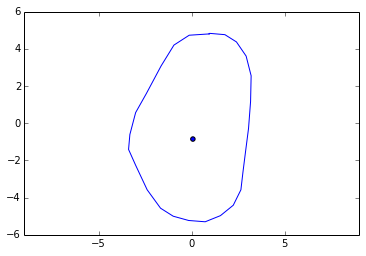

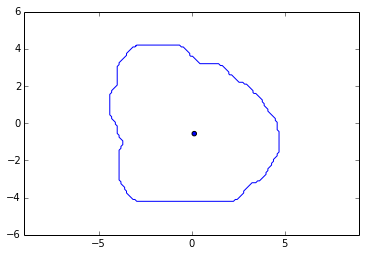

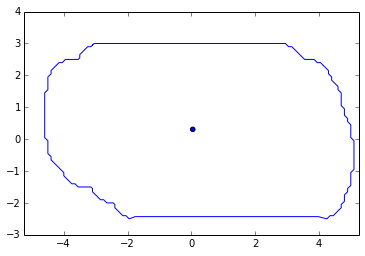

KeyboardInterrupt: 

In [21]:
shapeCentres = [0,] * len(label)

for i in np.where(calcWidthLength)[0]:

# for i in range(1):
    
    cutoutXCoords, cutoutYCoords = return_coords(label[i])
    
    shapeCentres[i] = find_centre(x=cutoutXCoords,
                                y=cutoutYCoords,
                                circle_fit=circle_fit,
                                n=2,
                                ignoreUnexpectedIntersection=True)   
    
#     print(shapeCentres[i].numCalls)
    plt.plot(shapeCentres[i].cutout.exterior.xy[0], shapeCentres[i].cutout.exterior.xy[1])
    plt.scatter(shapeCentres[i].centre[0], shapeCentres[i].centre[1])

    plt.axis("equal")  

    plt.show()
    


In [ ]:
# produce error if any centre point is closer to edge than min edge distance
# a distance function in shapely? or calc it myself

### Straighten the shapes

### Recalc the length and width

### Compare length and width to previous values

### Loop previous steps if required

### Save length and width results

### Create and output report

## Here be dragons

In [ ]:
cutoutXCoords, cutoutYCoords = return_coords(label[22]) 

test = find_centre(x=cutoutXCoords,
                   y=cutoutYCoords,
                   circle_fit=circle_fit,
                   debug=True,
                   n=2,
                   confidence=0.00001,
                   sectors=100)

test.centre

In [ ]:
plt.plot(test.cutout.exterior.xy[0],test.cutout.exterior.xy[1])
plt.scatter(test.centre[0],test.centre[1])



plt.axis("equal")  
plt.xlim([-5,5])
plt.ylim([-5,5])

test.centre

In [ ]:
sectorIntegrationTest = sector_integration(x=cutoutXCoords,
                                           y=cutoutYCoords,
                                           circle_fit=circle_fit,
                                           centre=test.centre)

sectorIntegrationTest.factor

In [ ]:
cutoutXCoords, cutoutYCoords = return_coords(label[22]) 

test = sector_integration(x=cutoutXCoords,
                          y=cutoutYCoords,
                          circle_fit=circle_fit,
                          centre=[(2.5,-2)])


plt.plot(test.cutout.exterior.xy[0],test.cutout.exterior.xy[1])

plt.plot(test.boundary.exterior.xy[0],test.boundary.exterior.xy[1])
plt.scatter(test.boundary.exterior.xy[0],test.boundary.exterior.xy[1])


for i in range(100):
    
    plt.plot(test.sectorMidline[i].xy[0],test.sectorMidline[i].xy[1],'g')
    
    if type(test.intersectionSet[i]) is geo.point.Point:        
        plt.scatter(test.intersectionSet[i].xy[0],test.intersectionSet[i].xy[1])
        
    elif type(test.intersectionSet[i]) is geo.multipoint.MultiPoint:        
        for point in test.intersectionSet[i]:
            plt.scatter(point.xy[0],point.xy[1])  
    
    
plt.axis("equal")  
plt.xlim([-5,5])
plt.ylim([-5,5])

test.factor

In [ ]:
n = 100
resolution = int(n/4)
cutoutRef = 22

spline = make_spline_model(width=guessWidth[useForFitting],
                                length=guessLength[useForFitting],
                                factor=factor[useForFitting])
                   

cutoutXCoords, cutoutYCoords = return_coords(label[cutoutRef])                  

sectorIntegration = find_centre(x=cutoutXCoords,
                                y=cutoutYCoords,
                                spline=spline,
                                circle_fit=circle_fit)

# circle_fit = sectorIntegration.circle_fit


centre = [(2.5,-3.4)]

cutout = shapely_cutout(*return_coords(label[cutoutRef]))  #20 / 21 22
plt.plot(cutout.exterior.xy[0],cutout.exterior.xy[1])

centreIsWithin = cutout.contains(geo.Point(centre))


circle = geo.Point(centre).buffer(applicatorRequest*np.sqrt(2),resolution=resolution)
plt.plot(circle.exterior.xy[0],circle.exterior.xy[1])
plt.scatter(circle.exterior.xy[0],circle.exterior.xy[1])


sectorMidline = [0,]*n
intersectionSet = [0,]*n

sectorEstimate = np.zeros(n)

for i in range(n):

    sectorMidline[i] = geo.LineString(centre + [circle.exterior.coords[i]])

    plt.plot(sectorMidline[i].xy[0],sectorMidline[i].xy[1],'g')

    intersectionSet[i] = sectorMidline[i].intersection(cutout.exterior)

    if type(intersectionSet[i]) is geo.point.Point:

        plt.scatter(intersectionSet[i].xy[0],intersectionSet[i].xy[1])
        
        if centreIsWithin:
            
            sectorEstimate[i] = circle_fit(sectorMidline[i].project(intersectionSet[i]))
        
        else:
            
            raise Exception("Unexpected midline intersection")

    elif type(intersectionSet[i]) is geo.multipoint.MultiPoint: 
            
        dist = np.zeros(len(intersectionSet[i]))
        for j in range(len(intersectionSet[i])):

            point = intersectionSet[i][j]
            dist[j] = sectorMidline[i].project(point)
            plt.scatter(point.xy[0],point.xy[1])
            

        dist = np.sort(dist)

        if (np.mod(len(intersectionSet[i]),2) == 1) & (centreIsWithin):

            sectorEstimate[i] = sum(circle_fit(dist[::2])) - sum(circle_fit(dist[1::2]))

        elif (np.mod(len(intersectionSet[i]),2) == 0) & (not(centreIsWithin)):

            sectorEstimate[i] = sum(circle_fit(dist[1::2])) - sum(circle_fit(dist[::2]))

        else:

            raise Exception("Unexpected midline intersection")
            
            
    elif (sectorMidline[i].disjoint(cutout.exterior)) & (not(centreIsWithin)):
        # No intersection
        0        

    else:

        raise Exception("Unexpected midline intersection")

    

        
        
    
    
    
plt.axis("equal")  
plt.xlim([-5,5])
plt.ylim([-5,5])


np.mean(sectorEstimate)

In [ ]:
test.sectorFactors- sectorEstimate

np.mean(sectorEstimate)

In [ ]:
np.mean(test.sectorFactors)

In [ ]:
sectorMidline[i].disjoint(cutout.exterior)

In [ ]:
intersectionSet[i]

type(intersectionSet[6]) is geo.point.Point

type(intersectionSet[6]) is geo.multipoint.MultiPoint


In [ ]:
intersectionSet

In [ ]:
i = 10
sectorMidline[i].project(intersectionSet[i])

In [ ]:
circle_fit(sectorMidline[i].project(intersectionSet[i]))

In [ ]:
i = 6

dist = np.zeros(len(intersectionSet[i]))
for j in range(len(intersectionSet[i])):
    
    point = intersectionSet[i][j]
    dist[j] = sectorMidline[i].project(point)

dist = np.sort(dist)

    
if (np.mod(len(intersectionSet[i]),2) == 1) & (centreIsWithin):
    
    sectorEstimate = sum(circle_fit(dist[::2])) - sum(circle_fit(dist[1::2]))
    
elif (np.mod(len(intersectionSet[i]),2) == 0) & (not(centreIsWithin)):
    
    sectorEstimate = sum(circle_fit(dist[1::2])) - sum(circle_fit(dist[::2]))
    
else:
    
    raise Exception("Unexpected midline intersection")




    

In [ ]:
sectorEstimate

In [ ]:
dist

In [ ]:
circle_fit(dist)

In [ ]:
circle_fit(dist[::2])

In [ ]:
circle_fit(dist[1::2])

In [ ]:
sum(circle_fit(dist[::2])) - sum(circle_fit(dist[1::2]))

In [ ]:
sum(circle_fit(dist[1::2])) - sum(circle_fit(dist[::2]))

In [ ]:
circle_fit(dist[1::2])

In [ ]:
(np.mod(4,2) == 0)

In [ ]:
intersectionSet[i]

In [ ]:
not(centreIsWithin)

In [ ]:
cutout.bounds

In [ ]:
np.hypot(np.diff(cutout.bounds[::2]),np.diff(cutout.bounds[1::2]))/3
